In [1]:
from pathlib import Path
import numpy as np
import datetime
import json
import os
from PIL import Image
from cropmask.coco_convert import split_save_train_validation_test_df, save_coco_annotation, create_coco_dataset
from cropmask.misc import parse_yaml, make_dirs

from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.
from detectron2.data.datasets import register_coco_instances, load_coco_json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor, launch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale
from cropmask.detectron2_cropmask_cfg import cfg
from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.


param_path = "/home/ryan/work/CropMask_RCNN/test_inspection_config.yaml"
params = parse_yaml(param_path)
tiles_path = Path(os.path.join(params['dirs']['root'], params['dirs']['dataset'], "tiles"))

train, validation, test = split_save_train_validation_test_df(tiles_path, save_empty_tiles=False)
coco_path = Path(params['dirs']['root']) / params['dirs']['dataset'] / "coco"

train_coco_instances_path = str(coco_path / "instances_train.json")
val_coco_instances_path = str(coco_path / "instances_val.json")
test_coco_instances_path = str(coco_path / "instances_test.json")

/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/miniconda3/envs/cropmask/lib/pyt

In [2]:
if (coco_path / "instances_train.json").exists() is False:
    train_coco_dict = create_coco_dataset(train)
    val_coco_dict = create_coco_dataset(validation)
    test_coco_dict = create_coco_dataset(test)
    save_coco_annotation(train_coco_instances_path, train_coco_dict)
    save_coco_annotation(val_coco_instances_path, val_coco_dict)
    save_coco_annotation(test_coco_instances_path, test_coco_dict)
# register each val and test set if there are more than one.
register_coco_instances(cfg.DATASETS.TRAIN[0], {}, train_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances(cfg.DATASETS.VALIDATION[0], {}, val_coco_instances_path, str(next(tiles_path.glob("*image*"))))
register_coco_instances(cfg.DATASETS.TEST[0], {}, test_coco_instances_path, str(next(tiles_path.glob("*image*"))))

train_json = load_coco_json(train_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
val_json = load_coco_json(val_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
test_json = load_coco_json(test_coco_instances_path,  str(next(tiles_path.glob("*image*"))))
os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)

100%|██████████| 3/3 [00:00<00:00, 22.67it/s]


instances_train.json saved.
instances_val.json saved.
instances_test.json saved.
[01/30 06:49:22 d2.data.datasets.coco]: Loaded 18 images in COCO format from /datadrive/test-ard-june-sept-rgb/coco/instances_train.json
[01/30 06:49:22 d2.data.datasets.coco]: Loaded 3 images in COCO format from /datadrive/test-ard-june-sept-rgb/coco/instances_val.json
[01/30 06:49:22 d2.data.datasets.coco]: Loaded 3 images in COCO format from /datadrive/test-ard-june-sept-rgb/coco/instances_test.json


FileExistsError: [Errno 17] File exists: '/home/ryan/work/cropmask_experiments/test1'

In [1]:
trainer = detectron2_reclass.Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

6

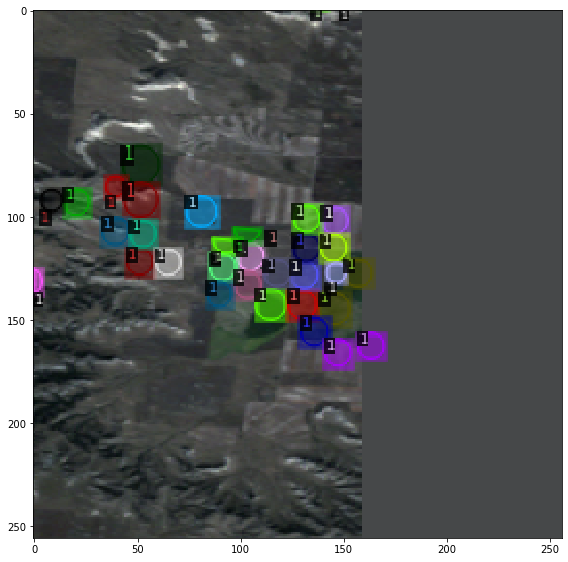

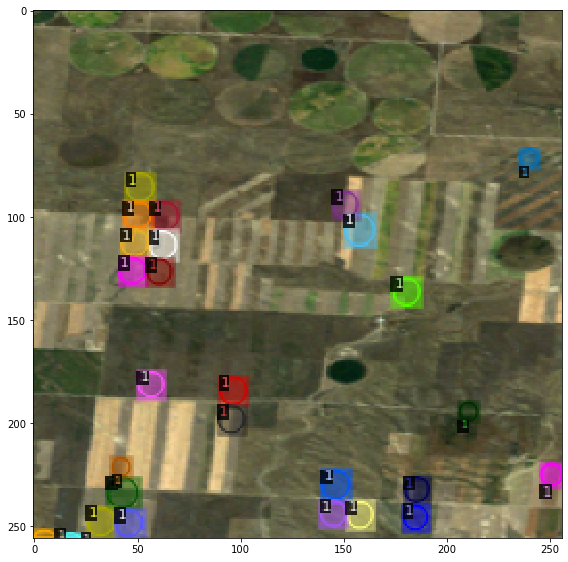

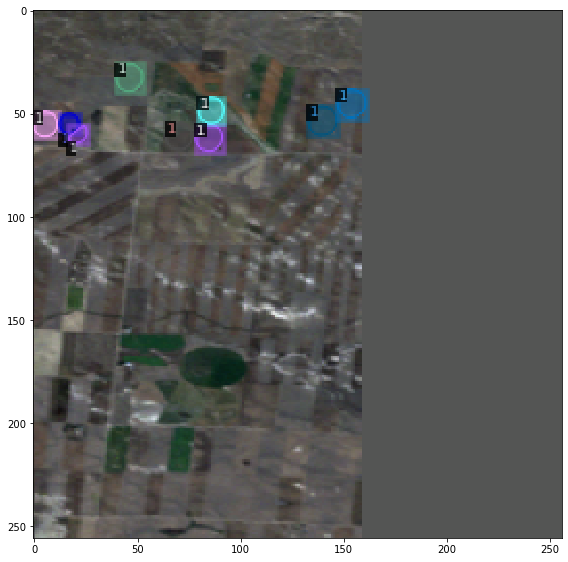

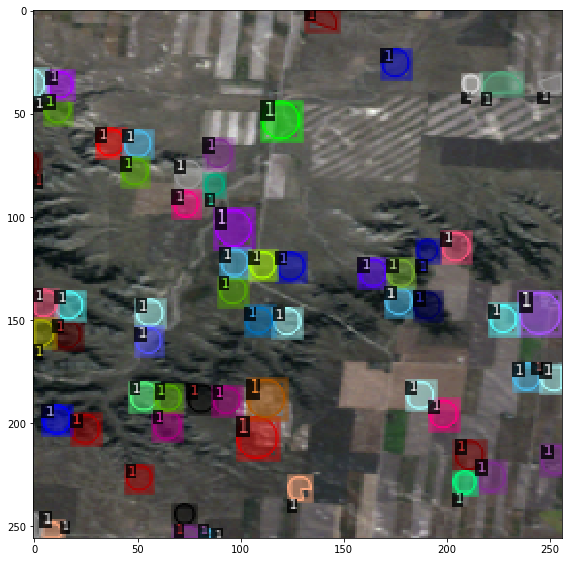

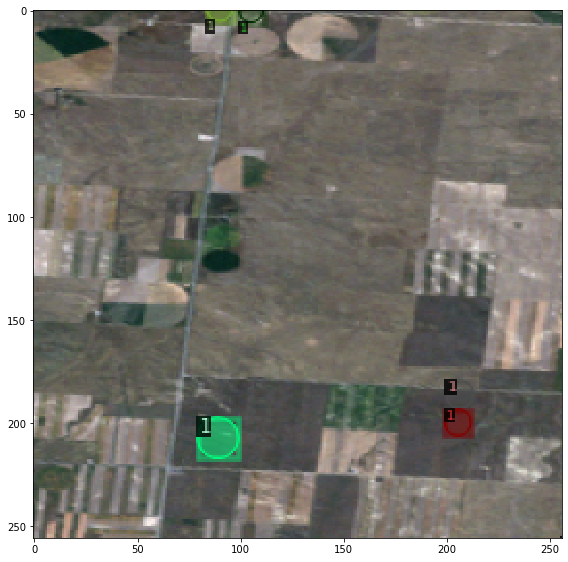

In [3]:
def max_norm_channels(arr):
    """
    arr must be of shape (w, h, channel)
    """
    arr = arr.copy()
    maxes = np.nanmax(arr, axis=(0,1))
    return arr / maxes

for d in random.sample(train_json, 5):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        img = img[:, :, ::-1]
        normalized = max_norm_channels(np.where(img < 0, 0, img))
        rescaled = rescale_intensity(normalized, out_range=(0,255))
        masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(masked, metadata={}, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (8,16))
        imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

In [2]:
from pathlib import Path

# Profiling/Debugging solaris raster tiler and filling nan values with means

In [3]:
scene_path = list(Path("/datadrive/test-ard-june-sept-nirrg/scene").glob("LT05_CU_*"))[3]

IndexError: list index out of range

In [ ]:
scene_path

In [ ]:
import xarray 
import rioxarray
xarr = xarray.open_rasterio(scene_path)

xarr = xarr.transpose("y", "x", "band")

xarr = xarr.where(xarr != -9999.0)/32767

In [ ]:
np.flip(xarr, axis=-1).plot.imshow()

In [ ]:
import us
from cropmask import io_utils
import xarray
import rioxarray
nebraska_url = us.states.NE.shapefile_urls('state')
gdf = io_utils.zipped_shp_url_to_gdf (nebraska_url)
crs=xarray.open_rasterio(scene_path).rio.crs
bounds_poly = gdf.to_crs(crs)['geometry'].iloc[0]

In [ ]:
from solaris.utils.core import _check_crs, _check_rasterio_im_load

In [ ]:
src = _check_rasterio_im_load(str(scene_path))

In [ ]:
from shapely.geometry import box
mask_geometry = bounds_poly.intersection(box(*src.bounds)) # prevents enlarging raster to size of aoi_boundary

In [ ]:
from rasterio.mask import mask as rasterio_mask
import rasterio

In [ ]:
arr, transform = rasterio_mask(src, [mask_geometry], all_touched=False, invert=False, nodata=src.meta['nodata'], filled=True, crop=False, pad=False, pad_width=0.5, indexes=[1,2,3])

with rasterio.open("/datadrive/tmp-masked.tif", 'w', **src.profile) as dest:
    dest.write(arr)
    dest.close()
src = _check_rasterio_im_load("/datadrive/tmp-masked.tif")

In [ ]:
arr, transform = rasterio_mask(src, [mask_geometry], all_touched=False, invert=False, nodata=src.meta['nodata'], filled=False, crop=False, pad=False, pad_width=0.5, indexes=[1,2,3])

In [ ]:
def fill_by_mean(arr):
    """
    Fills a masked array of shape (channel, H, W) by the channel means of the whole array for each channel.
    This is used to fill the channel means of the image that is tiled if fill_by_mean=True.
    """
    means = arr.mean(axis=(1,2))
    arr.soften_mask()
    for i,mean in enumerate(means):
        arr[i][arr.mask[i]==True] = mean


In [ ]:
arr.soften_mask()
arr[0][0] = np.ma.masked

In [ ]:
arr[1]

In [ ]:
means[1]

In [ ]:
src.profile

In [ ]:
tile_path = '/datadrive/test-ard-june-sept-nirrg/tiles/image_tiles/LT05_CU_013009_20050711_20190102_C01_V0_-511746_1962203.tif'

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()
xarr = xarray.open_rasterio(scene_path)

xarr = xarr.transpose("y", "x", "band")

xarr = xarr.where(xarr != -9999.0)/32767


gpd.GeoDataFrame(geometry=[bounds_poly]).plot(ax=ax, color=None,edgecolor='k', facecolor="none")
np.flip(xarr, axis=-1).plot.imshow(ax=ax)

In [ ]:
from shapely.ops import cascaded_union
from shapely.geometry import box
total_shape = cascaded_union([box(*i) for i in raster_tiler.tile_bounds])

In [ ]:
total_shape

In [ ]:
raster_bounds_crs = raster_tiler.tile(str(scene_path))

In [ ]:
if isinstance(bounds_poly, str):
    gj = json.loads(open(geometry).read())

    features = gj['features']
    if not len(features) == 1:
        print('Feature collection must only contain one feature')
        sys.exit(1)

    geometry = shape(features[0]['geometry'])

elif isinstance(geometry, list) or isinstance(geometry, np.ndarray):
    assert len(geometry) == 4
    geometry = box(*geometry)

In [ ]:
# sample_g = geojson_lst[0:5]

# sample_g = sample_g[::-1]

# sample_i = img_lst[0:5]

# gdf = gpd.read_file(geojson_lst[183])

# from solaris.vector.polygon import remove_multipolygons

# gdf['geometry'][0]

# remove_multipolygons(gdf).reset_index(drop=True)

# remove_multipolygons(gdf)['geometry'][0]

# import geopandas as gpd
# gpd.read_file(geojson_lst[183])['geometry'][0]